In [7]:
import pandas as pd
import numpy as np
import itertools
from final_files.config import *
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from glob import glob
from sqlalchemy import create_engine
import os

In [114]:
def query_AI(table, subname='', log=False):
    db_connection_str = f"mysql+pymysql://{config_ai['user']}:{config_ai['password']}@{config_ai['host']}:{config_ai['port']}/{config_ai['database']}"
    engine = create_engine(db_connection_str)
    if subname:
        fullname = table+'_'+subname
    else:
        fullname = table
    df = pd.read_sql(f'SELECT * FROM daytriptour_ai.{fullname}', con=engine)
    if log: 
        print(f'READ DB_AI: {fullname}')
    return df

def query_dtt(table):
    db_connection_str = f"mysql+pymysql://{config_dtt['user']}:{config_dtt['password']}@{config_dtt['host']}:{config_dtt['port']}/{config_dtt['database']}"
    engine = create_engine(db_connection_str)
    df = pd.read_sql(f'SELECT * FROM dtt.{table}', con=engine)
    print(f'READ DB_DTT: {table}')
    return df

def recommend_products(df_similarity, customer_id, n=5, ascending=False):
    customer_scores = df_similarity.loc[customer_id].sort_values(ascending=ascending)
    # print(customer_scores[:n])
    top_n_products = customer_scores.index[:n].tolist()
    # print(top_n_products)
    return top_n_products

def recommend_top_n(df_similarity, df_distance, customer_id, top_n=10):
    # need load df_user_vector and len(cleanHistory_list) < 10
    VECTOR_DIR = 'vector_data_fullVector'
    df_full_vector = query_AI(VECTOR_DIR, log=False)
    top_50 = list(map(int,recommend_products(df_similarity, customer_id, n=50)))
    history_list = df_full_vector[df_full_vector['new_id']== customer_id]['product_id'].tolist()
    cleanHistory_list = list(itertools.filterfalse(lambda x: x in history_list, top_50))

    customer_scores = df_distance.loc[customer_id].sort_values(ascending=True).index.tolist()
    distance_list = list(map(int,customer_scores))
    recommend_ls = list(itertools.filterfalse(lambda x: x not in cleanHistory_list, distance_list))[:top_n]
    return recommend_ls

In [4]:
def softmax(x, axis = 1):
    return np.exp(x)/np.sum(np.exp(x),axis=axis, keepdims=True)

In [76]:
df_product = query_dtt('dtt_product')
ls = df_product[df_product['is_active']==0]['product_id'].tolist()
df_user_item_similarity = query_AI('matrix_data_similarity','user_item')
df_user_item_similarity.drop(columns=map(str, ls), inplace=True, errors='ignore')
df_user_item_similarity.set_index('new_id', inplace=True)
df_user_item_distance = query_AI('matrix_data_distance','user_item')
df_user_item_distance.drop(columns=map(str, ls), inplace=True, errors='ignore')
df_user_item_distance.set_index('new_id', inplace=True)

df_full_vector = query_AI('vector_data_fullVector', log=False)

df_newUser = query_AI('clean_data')
df_newUser = df_newUser.drop_duplicates(subset='new_id')[user_cols]

df_month_vector = query_AI('vector_data_month')
df_month_vector.set_index('product_id', inplace=True)
df_month_vector.drop(index=map(int, ls), inplace=True, errors='ignore')

df_month_vector_v2 = df_month_vector.copy()
df_month_vector_v2[month_cols] = softmax(df_month_vector[month_cols].to_numpy(),axis=0)

READ DB_DTT: dtt_product


In [60]:
customer_id = 12774
top_50 = list(map(int,recommend_products(df_user_item_similarity, customer_id, n=50, ascending=False)))
history_list = df_full_vector[df_full_vector['new_id']== customer_id]['product_id'].tolist()
cleanHistory_list = list(itertools.filterfalse(lambda x: x in history_list, top_50))
customer_scores = df_user_item_distance.loc[customer_id].sort_values(ascending=True).index.tolist()
distance_list = list(map(int,customer_scores))
print('==='*10)
print(df_user_item_distance.loc[customer_id].sort_values(ascending=True)[20])
recommend = list(itertools.filterfalse(lambda x: x not in cleanHistory_list, distance_list))[:10]
recommend

185    0.999563
121    0.999274
132    0.998894
176    0.998386
177    0.997794
196    0.997306
69     0.996982
133    0.995994
170    0.994847
204    0.992744
152    0.992421
162    0.991204
178    0.990733
29     0.990338
140    0.990273
207    0.990273
57     0.990273
180    0.990098
58     0.989719
143    0.989559
171    0.988607
147    0.988455
43     0.988285
188    0.987389
73     0.987329
82     0.986871
206    0.986079
205    0.986079
76     0.986047
81     0.985722
141    0.985695
46     0.985097
102    0.984883
128    0.983740
172    0.983509
124    0.983365
49     0.983003
148    0.982975
105    0.982626
91     0.982391
103    0.982164
34     0.981465
35     0.978747
202    0.977248
200    0.974790
187    0.973047
160    0.972952
87     0.972586
122    0.971146
182    0.969646
Name: 12774, dtype: float64
['185', '121', '132', '176', '177', '196', '69', '133', '170', '204', '152', '162', '178', '29', '140', '207', '57', '180', '58', '143', '171', '147', '43', '188', '73', '8

[185, 69, 196, 162, 133, 176, 177, 132, 204, 43]

In [6]:
df_month_vector

,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
product_id,,,,,,,,,,,,
29,3.010526e-02,3.010526e-02,2.224495e-01,1.107511e-02,3.010526e-02,1.107511e-02,4.074305e-03,4.074305e-03,0.011075,0.011075,0.030105,0.604680
34,2.648578e-10,1.202453e-14,2.415191e-13,1.318649e-11,2.415191e-13,1.957049e-09,8.658248e-04,1.068513e-07,0.000016,0.047272,0.949492,0.002354
35,1.374102e-02,1.015332e-01,3.735196e-02,1.374102e-02,1.374102e-02,1.015332e-01,2.759957e-01,3.735196e-02,0.013741,0.013741,0.101533,0.275996
38,4.862669e-03,3.276441e-05,2.420980e-04,1.205335e-05,1.788876e-03,8.906289e-05,3.276441e-05,2.420980e-04,0.000658,0.721684,0.004863,0.265493
43,1.782938e-02,9.734509e-01,6.559061e-03,1.201334e-04,4.419460e-05,4.419460e-05,4.419460e-05,4.419460e-05,0.000044,0.000044,0.000888,0.000888
...,...,...,...,...,...,...,...,...,...,...,...,...
202,7.321896e-07,1.341052e-08,1.341052e-08,1.341052e-08,9.909109e-08,1.341052e-08,1.341052e-08,1.341052e-08,0.000002,0.000295,0.119167,0.880534
204,7.090518e-02,8.303456e-02,5.695640e-02,6.371256e-02,4.275563e-02,4.388887e-02,7.102573e-02,6.117003e-02,0.103040,0.068072,0.093982,0.241457
205,6.083314e-02,1.193272e-01,9.544215e-02,4.509853e-02,4.162759e-02,3.599415e-02,3.529445e-02,4.439884e-02,0.049741,0.039859,0.199536,0.232847


In [37]:
df_full_vector

,customer_id,new_id,product_id,browser,platform,customer_firstname,customer_lastname,customer_email,customer_gender,customer_nationality,customer_country,customer_phone_iso,customer_phone_code,order_price_paid,order_state,order_payment_by,order_quantity_infant,order_quantity_children,order_quantity_adult,order_quantity_elder,order_departure_date,date_create,booked_days,departure_year,departure_month,departure_week,departure_day,departure_DayofYear,departure_DayofWeek,country_code,sum_kids,sum_adults,private,group,family,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13,cat_14,cat_15,cat_16,cat_17,cat_18
0,0,10531,121,2,0,Julie,Staples,juliestaples40@gmail.com,2,british,77,77,77,0.450000,0,0,0,0,2,0,2018-10-29,2018-08-29 18:42:53,60,2018,10,44,29,302,0,77,0.000000,1.000000,0.576117,0.211942,0.211942,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714
1,0,12774,121,2,0,Alana,Locandro,alana.lannie@gmail.com,1,australian,13,13,13,0.450000,0,0,0,0,2,0,2018-10-30,2018-09-06 18:20:58,53,2018,10,44,30,303,1,13,0.000000,1.000000,0.576117,0.211942,0.211942,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714
2,0,12285,121,7,6,Harriet,Peace,Harrietpeace@icloud.com,1,british,77,77,77,0.450000,0,0,0,0,2,0,2018-11-23,2018-09-08 22:20:45,75,2018,11,47,23,327,4,77,0.000000,1.000000,0.576117,0.211942,0.211942,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714
3,221,221,121,8,0,Kain,Ingham,Kaino_01@hotmail.com,0,australian,13,13,13,0.450000,0,0,0,0,2,0,2018-09-15,2018-09-13 16:56:05,1,2018,9,37,15,258,5,13,0.000000,1.000000,0.576117,0.211942,0.211942,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714
4,0,12286,121,2,4,Sandra,Nicholl,sandinicholl@hotmail.co.uk,2,british,77,77,77,0.450000,0,0,0,0,7,0,2018-09-29,2018-09-21 22:12:06,7,2018,9,39,29,272,5,77,0.000000,1.000000,0.211942,0.576117,0.211942,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,0,11192,202,2,4,Ali,Mohammad,fourtwenty.aggregation@gmail.com,0,kuwait,123,38,38,0.358000,0,0,0,0,2,0,2023-01-11,2023-01-10 20:49:35,0,2023,1,2,11,11,2,123,0.000000,1.000000,0.576117,0.211942,0.211942,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714
5513,0,11193,202,2,4,Kirill,Kiryushin,kirill.kiryushin.o@gmail.com,0,russian,191,218,218,0.398000,0,0,0,0,2,0,2023-01-16,2023-01-14 20:47:14,1,2023,1,3,16,16,0,191,0.000000,1.000000,0.576117,0.211942,0.211942,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714
5514,0,11194,202,2,4,Paitoon,Uthaisang,puthaisang@gmail.com,0,thai,218,218,218,0.468000,0,0,0,0,3,0,2023-05-13,2023-01-15 16:12:44,117,2023,5,19,13,133,5,218,0.000000,1.000000,0.211942,0.576117,0.211942,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.050714,0.137856,0.050714,0.050714,0.050714,0.050714
5515,0,11195,202,2,0,Alex,Schetinin,shatz.g@gmail.com,0,israel,103,103,103,0.265333,0,0,1,0,2,0,2023-01-16,2023-01-16 15:30:44,0,2023,1,3,16,16,0,103,0.333333,0.666667,0.211942,0.211942,0.576117,0.050714,0.050714,0.050714,0.050714,0.05

In [13]:
# for i in month_cols:
#     plt.figure(figsize=(15, 4))
#     sns.barplot(x=df_month_vector.index, y=i, data=df_month_vector)
#     plt.xticks(rotation=90)
#     plt.show()

In [56]:
# for i in month_cols:
#     plt.figure(figsize=(15, 4))
#     sns.barplot(x=df_month_vector_2.index, y=i, data=df_month_vector_v2)
#     plt.xticks(rotation=90)
#     plt.show()

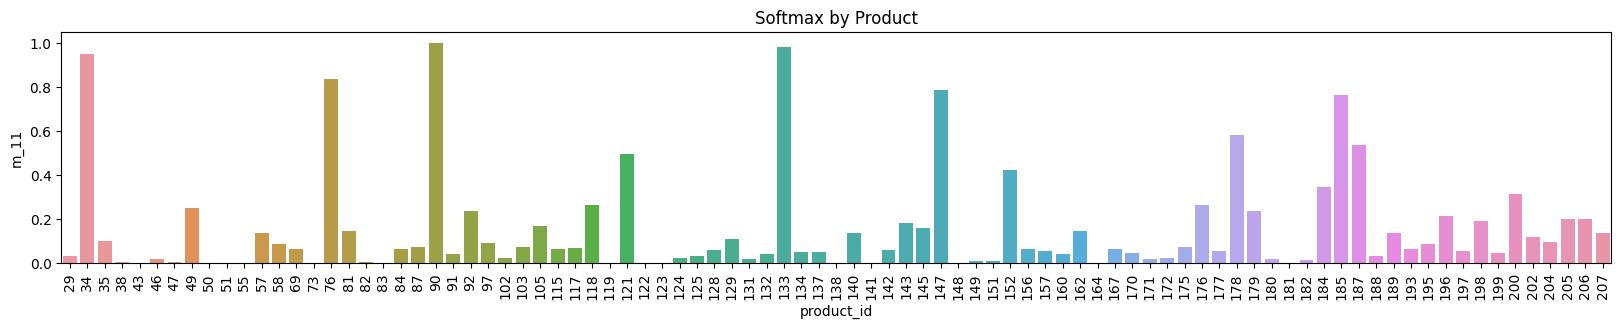

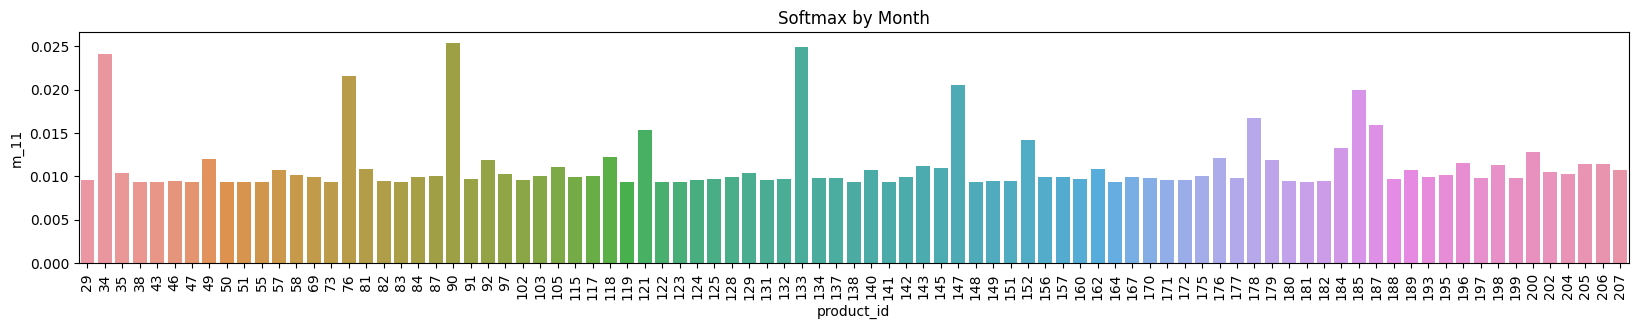

In [105]:
plt.figure(figsize=(20, 3))
sns.barplot(x=df_month_vector.index, y='m_11', data=df_month_vector)
plt.xticks(rotation=90)
plt.title('Softmax by Product')
plt.show()

plt.figure(figsize=(20, 3))
sns.barplot(x=df_month_vector_v2.index, y='m_11', data=df_month_vector_v2)
plt.title('Softmax by Month')
plt.xticks(rotation=90)
plt.show()

### minus the distance

In [127]:
customer_id = 12774
top_50 = list(map(int,recommend_products(df_user_item_similarity, customer_id, n=50, ascending=False)))
history_list = df_full_vector[df_full_vector['new_id']== customer_id]['product_id'].tolist()
cleanHistory_list = list(itertools.filterfalse(lambda x: x in history_list, top_50))
customer_scores = df_user_item_distance.loc[customer_id].sort_values(ascending=True).index.tolist()
distance_list = list(map(int,customer_scores))
recommend = list(itertools.filterfalse(lambda x: x not in cleanHistory_list, distance_list))[:10]
recommend

[185, 69, 196, 162, 133, 176, 177, 132, 204, 43]

In [134]:
customer_id = 11193
top_50 = list(map(int,recommend_products(df_user_item_similarity, customer_id, n=50, ascending=False)))
history_list = df_full_vector[df_full_vector['new_id']== customer_id]['product_id'].tolist()
cleanHistory_list = list(itertools.filterfalse(lambda x: x in history_list, top_50))
customer_scores = df_user_item_distance.loc[customer_id].sort_values(ascending=True)
b = customer_scores.copy()
for idx in b.index:
    b[str(idx)] = b[str(idx)]-df_month_vector_v2['m_11'][int(idx)]
distance_list_b = list(map(int,b.sort_values(ascending=True).index.tolist()[:10]))

In [135]:
for m in month_cols:
    b = customer_scores.copy()
    for idx in b.index:
        b[str(idx)] = b[str(idx)]-df_month_vector_v2[m][int(idx)]
    distance_list_b = list(map(int,b.sort_values(ascending=True).index.tolist()[:10]))
    print(m,distance_list_b)

m_1 [188, 185, 121, 69, 133, 171, 103, 102, 162, 29]
m_2 [188, 185, 121, 69, 171, 133, 103, 162, 102, 29]
m_3 [188, 185, 121, 69, 171, 133, 103, 162, 102, 29]
m_4 [188, 185, 121, 69, 133, 171, 102, 103, 162, 29]
m_5 [188, 185, 121, 69, 133, 171, 102, 103, 162, 29]
m_6 [188, 185, 121, 69, 133, 171, 103, 162, 102, 29]
m_7 [188, 185, 121, 69, 133, 171, 103, 162, 102, 29]
m_8 [188, 185, 121, 69, 171, 133, 103, 162, 102, 29]
m_9 [188, 185, 121, 69, 133, 171, 103, 162, 102, 29]
m_10 [188, 185, 121, 69, 133, 171, 103, 102, 162, 29]
m_11 [185, 188, 133, 121, 69, 171, 147, 103, 162, 102]
m_12 [188, 185, 121, 171, 69, 133, 102, 29, 103, 162]
